In [1]:
# NB: please make supe to apply a template to experiment plates in the ui before running this code

from ldm import ldm

raw_data = ldm.get_experiment_measurements('exp2', label='Label1')

pos_neg_norm_data = ldm.normalize_values(raw_data, pos_neg_only=True)
pos_neg_norm_data_log = ldm.normalize_values(raw_data, pos_neg_only=True, log_value=True)

norm_data = ldm.normalize_values(raw_data, label='Label1')
norm_data_log = ldm.normalize_values(raw_data, log_value=True)

Processing plate BAF210901_9
Processing plate BAF210901_8
Processing plate BAF210901_7
Processing plate BAF210901_6
Processing plate BAF210901_5
Processing plate BAF210901_4
Processing plate BAF210901_3
Processing plate BAF210901_25
Processing plate BAF210901_24
Processing plate BAF210901_23
Processing plate BAF210901_22
Processing plate BAF210901_21
Processing plate BAF210901_20
Processing plate BAF210901_2
Processing plate BAF210901_19
Processing plate BAF210901_18
Processing plate BAF210901_17
Processing plate BAF210901_16
Processing plate BAF210901_15
Processing plate BAF210901_14
Processing plate BAF210901_13
Processing plate BAF210901_12
Processing plate BAF210901_11
Processing plate BAF210901_10
Processing plate BAF210901_1

Found 9600 measurements


In [2]:
z_prime = ldm.calculate_z_prime(raw_data)
z_prime_log = ldm.calculate_z_prime(raw_data, log_value=True)

In [3]:
%get raw_data
%get pos_neg_norm_data
%get pos_neg_norm_data_log
%get norm_data
%get norm_data_log
%get z_prime
%get z_prime_log

In [8]:
# if you want to save something as a file, please save it in the /data/notebooks/ directory
# after that you can download it from the ui
write.csv(z_prime, "/data/notebooks/z.prime.csv", row.names = FALSE)

In [18]:
4 + 4

In [4]:
library(captioner)
library(RColorBrewer)
library(lawstat)
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:lawstat’:

    levene.test




In [5]:
type.pal = brewer.pal(9,"Set1")
type.pal = c(type.pal[2:1], "black", type.pal[3:9], brewer.pal(8,"Dark2"))


create_histogram_plot <- function(data, x_var, fill_range, title) {
      p = ggplot(data, aes(x = !!rlang::sym(x_var))) +
        geom_histogram(aes(fill = after_stat(count)), col = 'black', alpha = .2, bins = 30) +
        scale_fill_gradient("Count", low = fill_range[1], high = fill_range[2]) +
        ggtitle(title) +
        labs(x = x_var, y = "Count") +
        theme_bw() +
        theme(plot.title = element_text(hjust = 0.5)) 
        return(p)
}

create_scatterplot = function(data, x_var, y_var, y_label, x_label="") {
      p = ggplot(data, aes(x=!!rlang::sym(x_var),
                              y=!!rlang::sym(y_var),
                              group=!!rlang::sym(x_var),
                              color=!!rlang::sym(x_var))) +
        geom_jitter(width=0.2) +
        ylab(y_label) + xlab(x_label) +
        scale_color_manual(name="", values=type.pal, drop=F) +
        guides(color=guide_legend(ncol=1,byrow=T)) +
        theme(strip.text = element_text(size=10),
              axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=rel(0.99)),
              legend.position="right", legend.title=element_text(size=rel(0.8)),
              legend.text=element_text(size=rel(0.8)))

        return(p)
}

create_z_prime_plot = function(data, x_var, y_var) {
      data[, x_var] = as.factor(data[, x_var])  
      cols = brewer.pal(9,"Set1")[c(1,6,3)]

      p = ggplot(data, aes(x=!!rlang::sym(x_var), y=!!rlang::sym(y_var))) + ylab("Z'") + xlab("") +
      scale_y_continuous(limits=c(-0.5,1), expand = c(0,0))+
      geom_hline(yintercept=c(0,0.5)) +
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=-Inf, ymax=0, fill=cols[1], alpha=0.5) + 
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=0, ymax=0.5, fill=cols[2], alpha=0.5) + 
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=0.5, ymax=1, fill=cols[3], alpha=0.5) + 
      geom_point() +
      ggtitle("Z'-factor")+
      theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
            strip.text = element_text(size=10),
            plot.title = element_text(hjust = 0.5))

        return(p)
}

create_plate_control_bar_plot = function(data, x_var, y_var, fill_var, sd_var) {
        p = ggplot(data, aes(x=!!rlang::sym(x_var),
                             y=!!rlang::sym(y_var), 
                             fill=!!rlang::sym(fill_var)))+
          geom_bar(position=position_dodge(),
                   stat="identity",linewidth=.3) +
            geom_errorbar(aes(ymin=!!rlang::sym(y_var)-!!rlang::sym(sd_var), 
                              ymax=!!rlang::sym(y_var)+!!rlang::sym(sd_var)), 
                          linewidth=.3, width=.2,
                          position=position_dodge(.9)) +
            scale_fill_manual(values=type.pal, drop=F) +
            ylab("Value") +
            ggtitle("") +
            theme_bw() +
            theme(axis.text.x = element_text(angle=45, vjust = 1, hjust = 1),
              axis.title.x = element_blank()) 
        return(p)
}


create_qq_plot = function(data, title="Normal QQ Plot", pvar) {
    
    data$control = as.factor(data$control)    
    y = matrix(unlist(tapply(data$norm, data$control, quantile, c(0.25,0.75), na.rm=T)), 
               ncol=2, byrow=T)
    x = qnorm( c(0.25, 0.75))         # Find the matching normal values on the x-axis
    slope = t(diff(t(y))) / diff(x)   # Compute the line slope
    int = y[,1] - slope * x[1]      
    qqline = data.frame(int=int, slope=slope, type=levels(droplevels(data$control)))
    levels(qqline$type) = levels(data$control)

    p = ggplot(data, aes(sample=norm, group=control, color=control)) + 
      stat_qq(distribution = qnorm) +
      #annotate(geom="text", x=0, y=min(data$norm), col="red", label=paste("Shapiro's Test p= ", pnorm), parse=F)+
      annotate(geom="text", x=0, y=(min(data$norm)+0.05), col="red", label=paste("Levine's Test p= ", pvar), parse=F)+
      geom_abline(data = qqline, aes(intercept=int, slope=slope)) + 
      scale_color_manual(name="", values=type.pal, drop=F) +
      labs(x="Theoretical Quantiles", y="Signal Quantiles") + ggtitle(title)
    
      return(p) 
}



In [6]:
# Levene test
vartest = leveneTest(pos_neg_norm_data$value, as.factor(pos_neg_norm_data$control))
pvar = vartest$p.value
vartest_log <- leveneTest(pos_neg_norm_data_log$value, as.factor(pos_neg_norm_data_log$control))
pvar_log <- vartest_log$p.value

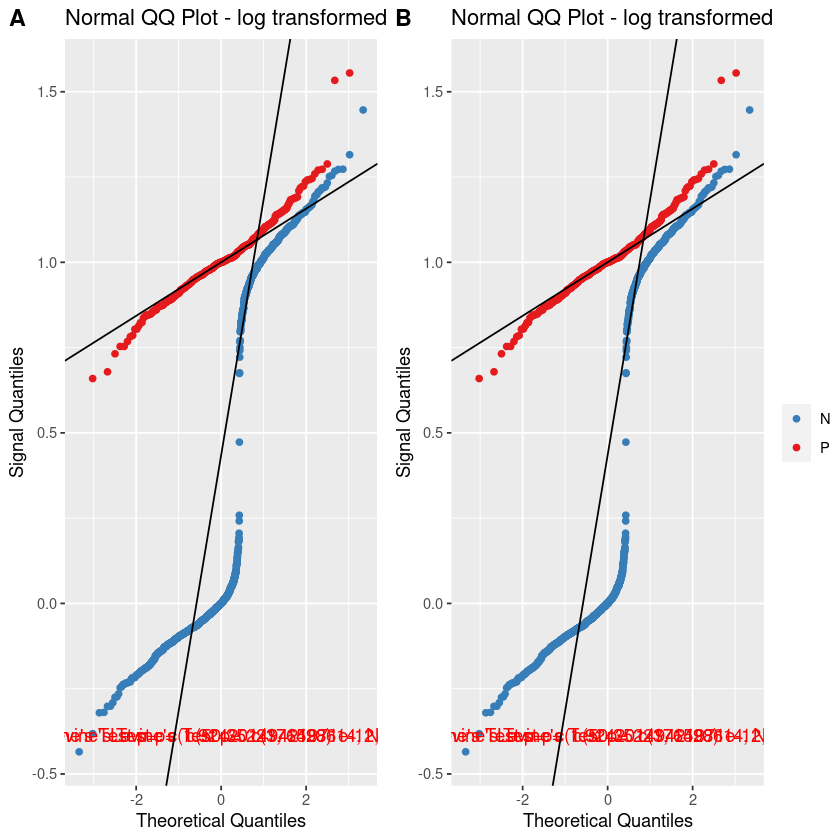

In [8]:
# QQ-plos
qq1 = create_qq_plot(pos_neg_norm_data, pvar = pvar)
qq1 = create_qq_plot(pos_neg_norm_data_log, "Normal QQ Plot - log transformed", pvar = vartest_log)
qq3 = ggarrange(qq1, qq1, ncol = 2, labels = "AUTO", common.legend = T, legend = "right")
qq3

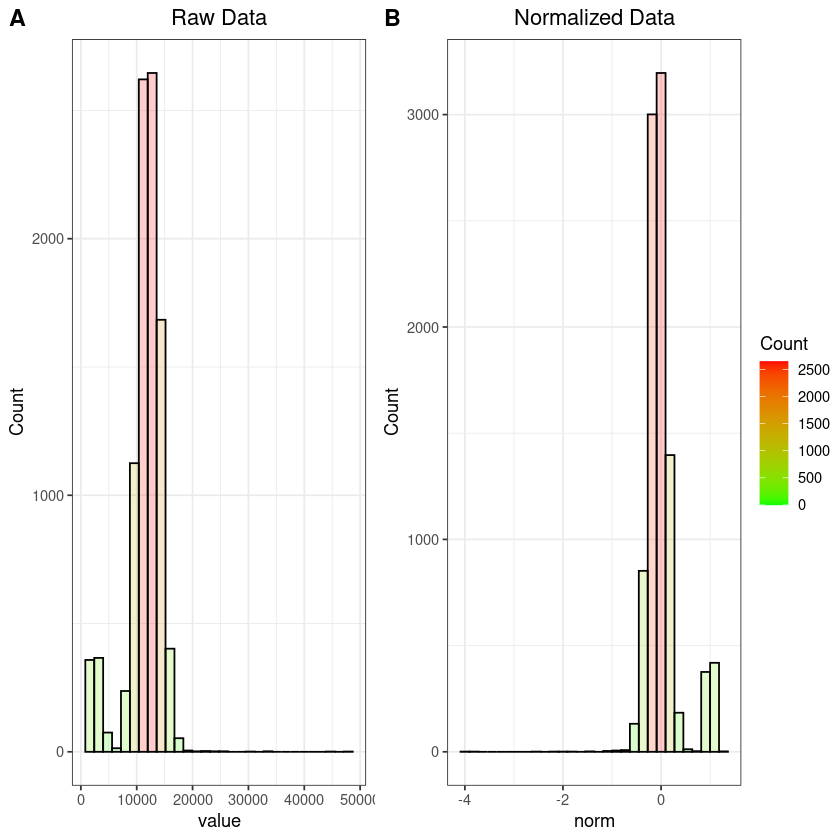

In [9]:
raw_data_hist <- create_histogram_plot(data = norm_data, x_var = "value", fill_range = c("green", "red"), title = "Raw Data")
norm_data_hist <- create_histogram_plot(data = norm_data, x_var = "norm", fill_range = c("green", "red"), title = "Normalized Data")
hist_combined = ggarrange(raw_data_hist, norm_data_hist, ncol = 2, labels = "AUTO", common.legend = T, legend = "right")
hist_combined

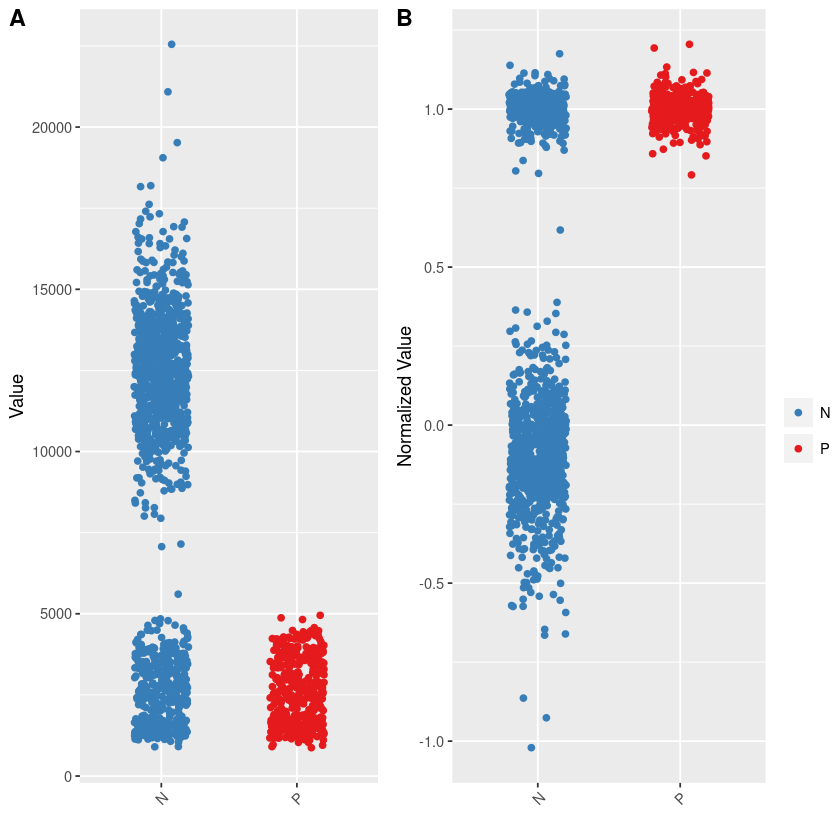

In [10]:
raw_data_scatter = create_scatterplot(pos_neg_norm_data, 'control', 'value', 'Value', "")
norm_data_scatter = create_scatterplot(pos_neg_norm_data, 'control', 'norm', 'Normalized Value', "")
scatter_combined = ggarrange(raw_data_scatter, norm_data_scatter, ncol = 2, labels = "AUTO", common.legend = T, legend = "right")
scatter_combined

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


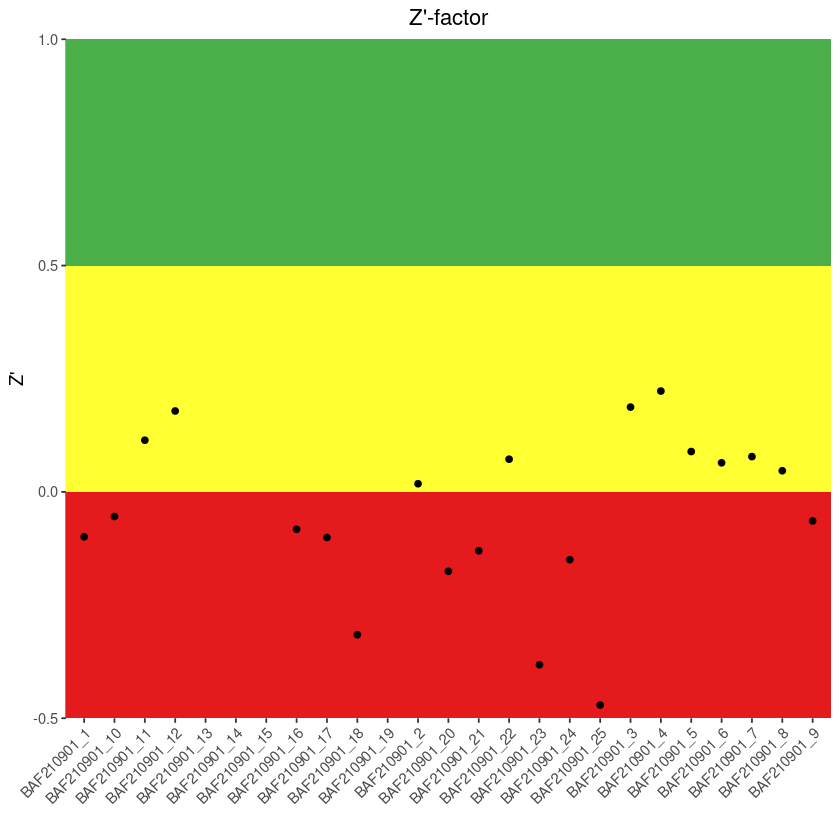

In [11]:
z_prime_plot = create_z_prime_plot(z_prime, 'plate', 'z_prime')
z_prime_plot

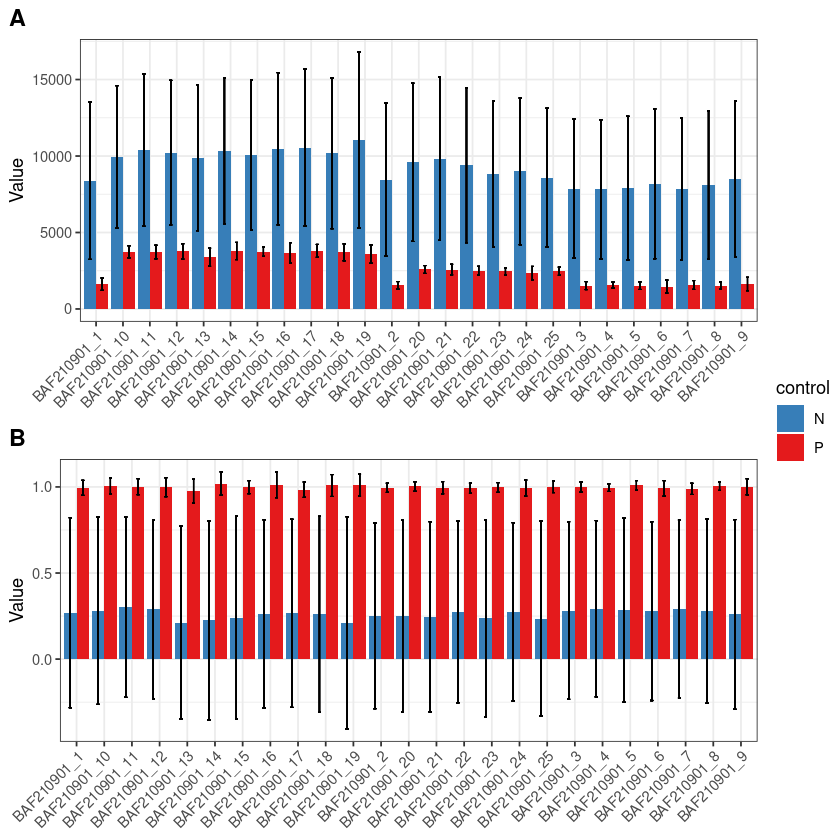

In [12]:
condat = norm_data %>% filter(control != 'C') %>%
    mutate(X.Axis = paste(plate, control)) 
mean_sd =  condat %>% 
    group_by(X.Axis) %>% 
    summarize(value_mean = mean(value), value_sd=sd(value), norm_mean=mean(norm), norm_sd=sd(norm))
res_df = left_join(condat, mean_sd, by="X.Axis")

plate_barplot_raw = create_plate_control_bar_plot(res_df, 'plate', 'value_mean', 'control', 'value_sd')
plate_barplot_norm = create_plate_control_bar_plot(res_df, 'plate', 'norm_mean', 'control', 'norm_sd')
barplot_combined = ggarrange(plate_barplot_raw, plate_barplot_norm, ncol = 1, labels = "AUTO", common.legend = T, legend = "right")
barplot_combined

In [13]:
target_dir="/data/notebooks"

if [ "$(pwd)" != "$target_dir" ]; then
  cd "$target_dir"
  echo "Changed directory to $target_dir"
else
  echo "Already in $target_dir"
fi

echo -e "\nDirectory content:\n$(ls)"

# TODO: make this work, at the moment it doesn't 
jupyter nbconvert --to pdf --no-input FirstReport.ipynb


Changed directory to /data/notebooks

Directory content:
FirstReport.html
FirstReport.ipynb
PreliminaryAnalysis.ipynb


In [ ]:
# cell
# cheers from dave